<br>  
<div style="align: center;">
    <img src="https://lh3.googleusercontent.com/G7-k5dkcdzU6D0D4OOmIohL4ocudGX_z8MuVy89ThCqj2E7aTawFopI-7CSmnyN-23a9nF1ilXZw53EtKb4GuiawEjG_8Fe97Qc2ZNZwHw" 
    style="display:block; margin:auto; width:55%; height:350px;">

<p style="text-align:center; background-color:romance; color: Jaguar; border-radius:10px 10px; font-family:newtimeroman; 
          line-height:1.4; font-size:32px; font-weight:bold; text-transform: capitalize;"><strong>Binary Cat-Dog Image Classification with CNN Project: Deep Learning Module</strong></p>   

<p style="text-align:center; background-color:romance; color: Jaguar; border-radius:10px 10px; font-family:newtimeroman; 
          line-height:1.4; font-size:28px; font-weight:medium; text-transform: capitalize;">Applied: Convolutional Neural Network with Data Augmentation ImageDataGenerator</p>
</div>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set includes 6897 cat and dogs images together. 

# Import Libraries and Export Images from Zip_File

## colab Package Update

⚠️ **need to restart**

In [1]:
!pip install -Uq matplotlib matplotlib-dashboard seaborn scikit-plot tensorflow-addons

## Import Libraries

In [2]:
import tensorflow as tf

print("Tensorflow version \t\t:" + tf.__version__)

# print("Available devices:")
# for i, device in enumerate(tf.config.list_logical_devices()):
#     print("%d) %s" % (i, device))

# check if tensorflow see the GPU
# tf.test.gpu_device_name()

print("Num physical_GPUs Available\t:", len(tf.config.list_physical_devices('GPU')))
print("Num physical_CPUs Available\t:", len(tf.config.list_physical_devices('CPU')))
print()
print("Num logical_GPUs Available\t:", len(tf.config.list_logical_devices('GPU')))
print("Num logical_CPUs Available\t:", len(tf.config.list_logical_devices('CPU')))

Tensorflow version 		:2.9.2
Num physical_GPUs Available	: 1
Num physical_CPUs Available	: 1

Num logical_GPUs Available	: 1
Num logical_CPUs Available	: 1


### Colab-only auth for this notebook and the TPU

In [3]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    # Authenticates the Colab machine and also the TPU using your
    # credentials so that they can access your private GCS buckets.
    auth.authenticate_user()

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### TPU or GPU detection

In [6]:
import tensorflow as tf

try:
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # tf.config.experimental_connect_to_cluster(resolver)
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # strategy = tf.distribute.TPUStrategy(resolver)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)    
    print('Running on TPU ', tpu.master(), len(tf.config.list_logical_devices('TPU')))
    
except ValueError:
    # If there's a GPU avaiable, to use the GPU, otherwise, using the CPU instead.
    gpus = tf.config.list_logical_devices('GPU')
    if len(gpus) > 1:        
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])           
        print('Running on multiple GPUs ', gpus)  
    elif len(gpus) == 1:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on single GPU ', gpus[0].name)
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on CPU')
        
print("Number of accelerators: ", strategy.num_replicas_in_sync)    
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)
# The style parameters control properties like the color of the background and whether a grid is enabled by default.
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.grid' : False})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Environment settings: 
# pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# pd.set_option('display.float_format', lambda x: '%.4f'%x)
# pd.options.display.float_format = '{:.4f}'.format
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 100)

In [8]:
import re
import random
import pathlib

from glob import glob
from matplotlib.image import imread
import scipy.stats as stats

### Parameters

In [9]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

seed = random_state = 101

print(BATCH_SIZE)
print(round(LEARNING_RATE*LEARNING_RATE_EXP_DECAY, 3))

64
0.006


## Ingest Data from links below

In [10]:
# # https://github.com/wkentaro/gdown
!pip install gdown -Uq
import gdown

# url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
url = 'https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download'
id  = '1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h'

output = 'cat_dog_data.zip'                          # download local colab etc.
# output = '/content/drive/MyDrive/cat_dog_data.zip' # download drive
gdown.download(url=url, output=output, quiet=False)

!unzip -oq $output # unzip from $output to local

Downloading...
From: https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download
To: /content/cat_dog_data.zip
100%|██████████| 595M/595M [00:06<00:00, 95.7MB/s]


In [11]:
# !unzip -oq /content/drive/MyDrive/yy-Data-Sources/cat_dog_data.zip

In [12]:
# Alternative method linux bash command
!sudo apt-get -qq install tree 
!tree -d ./data

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
./data
├── test
├── train
│   ├── cat
│   └── dog
└── validation
    ├── cat
    └── dog

7 directories


In [13]:
# import zipfile

# # Unzip the file
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cat_dog_data.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [14]:
# # Download Original Dataset
# import pathlib

# dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

# data_dir = tf.keras.utils.get_file(
#     fname='kagglecatsanddogs_5340.zip',
#     origin=dataset_url,
#     untar=False,  # use if tar
#     cache_subdir='.',
#     extract=True,
#     archive_format='auto',
#     cache_dir="."
# )
# data_dir = '/'.join(data_dir.split('/')[:-1])+"/PetImages"
# data_dir = pathlib.Path(data_dir)
# print(data_dir)

# image_count = len(list(data_dir.glob('**/*.jpg')))
# cat_count   = len(list(data_dir.glob('Cat/*.jpg')))
# dog_count   = len(list(data_dir.glob('Dog/*.jpg')))

# print(image_count)
# print(cat_count)
# print(dog_count)

# Recognizing and Understanding Data

In [15]:
data_dir = "./data"

train_path = data_dir+'/train'
val_path   = data_dir+'/validation'
test_path  = data_dir+'/test'

print(train_path, val_path, test_path, sep='\n')

./data/train
./data/validation
./data/test


**Let's check how many images there are.**

In [16]:
from glob import glob

train_file_paths = glob(train_path + '/*/*.jpg')
total_train_file = len(train_file_paths)

val_file_paths   = glob(val_path + '/*/*.jpg')
total_val_file   = len(val_file_paths)

test_file_paths  = glob(test_path + '/*.jpg')
total_test_file   = len(test_file_paths)

print(f'Train size\t: {total_train_file:<10}')
print(f'Val size\t: {total_val_file:<10}')
print(f'Test size\t: {total_test_file:<10}')

Train size	: 17526     
Val size	: 2290      
Test size	: 6897      


In [17]:
total_train = len(os.listdir(train_path+'/dog')) + len(os.listdir(train_path+'/cat'))
total_val   = len(os.listdir(val_path+'/dog')) + len(os.listdir(val_path+'/cat'))
total_test  = len(os.listdir(test_path))

print(f'Train size\t: {total_train:<10}')
print(f'Val size\t: {total_val:<10}')
print(f'Test size\t: {total_test:<10}')

Train size	: 17526     
Val size	: 2290      
Test size	: 6897      


In [18]:
# Walk through cell_images directory and list number of files
for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in './data'.
There are 2 directories and 0 images in './data/validation'.
There are 0 directories and 1071 images in './data/validation/dog'.
There are 0 directories and 1219 images in './data/validation/cat'.
There are 0 directories and 6897 images in './data/test'.
There are 2 directories and 0 images in './data/train'.
There are 0 directories and 5026 images in './data/train/dog'.
There are 0 directories and 12500 images in './data/train/cat'.


In [19]:
# Alternative method linux bash command
!find ./data -type f -printf "%h\n" | sort -k 1r | uniq -c 

   1071 ./data/validation/dog
   1219 ./data/validation/cat
   5026 ./data/train/dog
  12500 ./data/train/cat
   6897 ./data/test


In [20]:
# Alternative method linux bash command
# https://linuxize.com/post/bash-printf-command/
!find ./data/train -type f | printf "%-10s : %g\n" 'Train size' $(wc -l) && \
find ./data/validation -type f | printf "%-10s : %g\n" 'Val size' $(wc -l) && \
find ./data/test -type f | printf "%-10s : %g\n" 'Test size' $(wc -l) 

print()
# Alternative method linux bash command
bash = '''
find ./data/train -type f | echo 'Train size\t:' $(wc -l), && \
find ./data/validation -type f | echo 'Val size\t:' $(wc -l), && \
find ./data/test -type f | echo 'Test size\t:' $(wc -l)'''

import os
run = os.popen(bash).read().split(',')
print(*run)

Train size : 17526
Val size   : 2290
Test size  : 6897

Train size	: 17526 
Val size	: 2290 
Test size	: 6897



**Let's check how many classes there are.**

In [21]:
os.listdir(data_dir)

['validation', 'test', 'train']

In [22]:
os.listdir(train_path)

['dog', 'cat']

In [23]:
CLASS_NAMES = np.unique(os.listdir(train_path))
CLASS_NAMES

array(['cat', 'dog'], dtype='<U3')

In [24]:
# Alternative method
import pathlib

train_folders = pathlib.Path(train_path) # turn our training path into a Python path
CLASS_NAMES   = np.unique([item.name for item in train_folders.glob('*')]) # created a list of class_names from the subdirectories
print(CLASS_NAMES)

['cat' 'dog']


**Let's take an example images from both train-cat and train-dog folders to observe process** 

In [25]:
first_10_cat = sorted(glob(train_path+'/cat/*'))[:10]
print(first_10_cat)

['./data/train/cat/cat.0.jpg', './data/train/cat/cat.1.jpg', './data/train/cat/cat.10.jpg', './data/train/cat/cat.100.jpg', './data/train/cat/cat.1000.jpg', './data/train/cat/cat.10000.jpg', './data/train/cat/cat.10001.jpg', './data/train/cat/cat.10002.jpg', './data/train/cat/cat.10003.jpg', './data/train/cat/cat.10004.jpg']


In [26]:
cat_cell_path = first_10_cat[0]
cat_cell_path

'./data/train/cat/cat.0.jpg'

In [27]:
cat_cell = mpl.image.imread(cat_cell_path)
cat_cell.shape

(374, 500, 3)

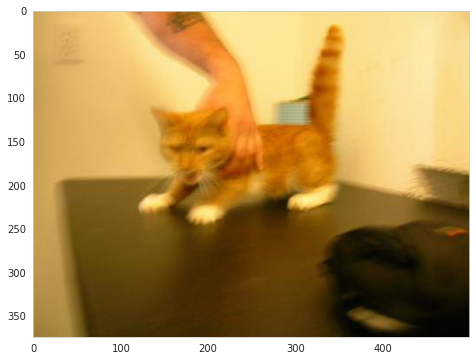

In [28]:
# plt.matshow(cat_cell);
plt.imshow(cat_cell);

In [29]:
first_10_dog = sorted(glob(train_path+'/dog/*'))[:10]
print(first_10_dog)

['./data/train/dog/2462.jpg', './data/train/dog/2464.jpg', './data/train/dog/2465.jpg', './data/train/dog/2466.jpg', './data/train/dog/2467.jpg', './data/train/dog/2468.jpg', './data/train/dog/2469.jpg', './data/train/dog/2470.jpg', './data/train/dog/2471.jpg', './data/train/dog/2472.jpg']


In [30]:
dog_cell_path = first_10_dog[0]
dog_cell_path

'./data/train/dog/2462.jpg'

In [31]:
dog_cell = mpl.image.imread(dog_cell_path)
dog_cell.shape

(286, 384, 3)

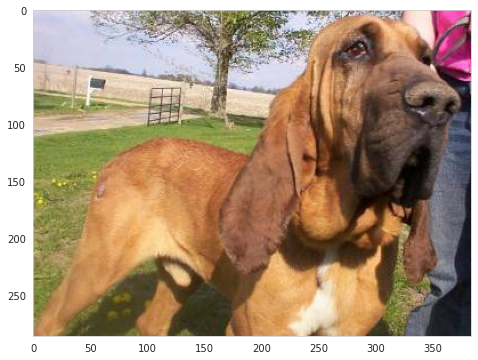

In [32]:
plt.imshow(dog_cell);

## let's check sample Image

In [33]:
def view_n_image(target_dir, target_class, start=0, end=15, col=5, random_N_img=0):
    # View a random image
    import random
    from glob import glob
    import matplotlib as mpl

    # Setup target directory (we'll view images from here)
    target_folder = target_dir +"/"+ target_class + "/*"

    # Get all image path
    image_list = sorted(glob(target_folder))

    if random_N_img:
        # Get a random image path
        image_list = random.sample(image_list, random_N_img)
    else:
        image_list = image_list[start:end]

    # Read in the image and plot it using matplotlib
    fig = plt.figure(figsize=(10, 10))  
    fig.suptitle(f'{target_folder}', y=.95)
    for i, image in enumerate(image_list, start=1):    
        ax = fig.add_subplot(int(np.ceil(len(image_list)/col)), col, i)   
        img = mpl.image.imread(image)
        ax.imshow(img)
        plt.xlabel(f'{img.shape}');
        plt.xticks([])
        plt.yticks([])
        ax.set_title(f"{target_class}")
        plt.grid(False)
        plt.tight_layout()

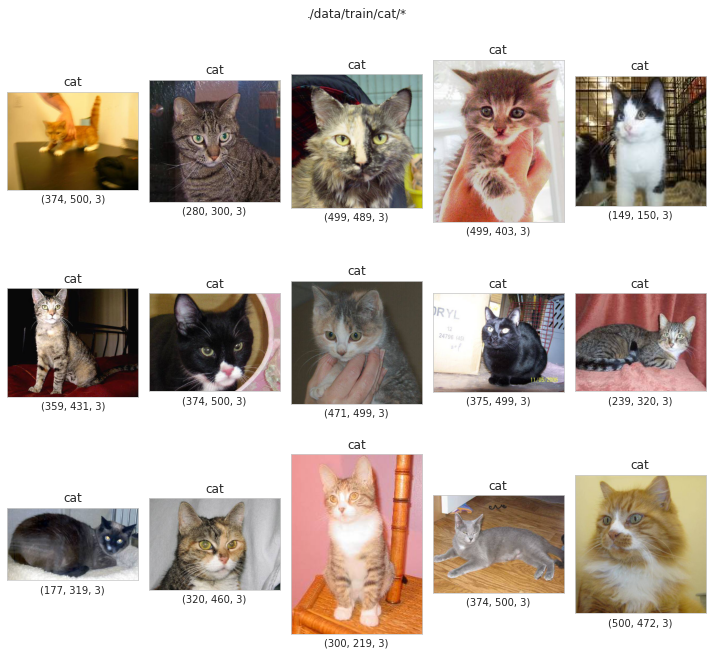

In [34]:
# View a first 15 image from the training dataset
view_n_image(
    target_dir=train_path,
    target_class="cat",
    start=0, end=15
)

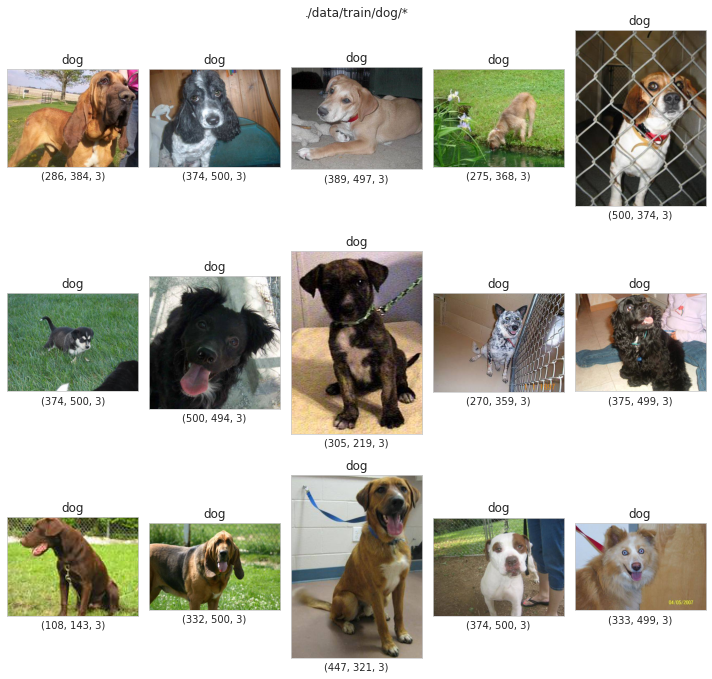

In [35]:
# View a first 15 image from the training dataset
view_n_image(
    target_dir=train_path,
    target_class="dog",
    start=0, end=15
)

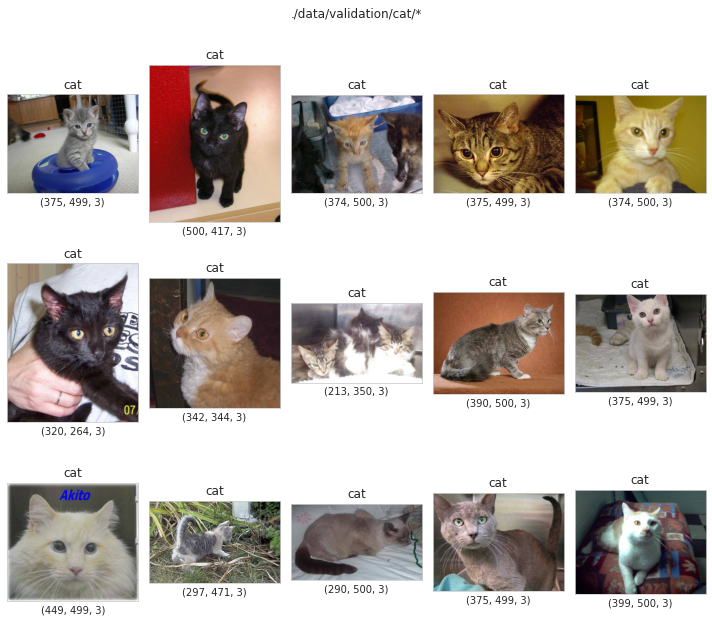

In [36]:
# View a random 15 image from the validation dataset
view_n_image(
    target_dir=val_path,
    target_class="cat",
    random_N_img=15
)

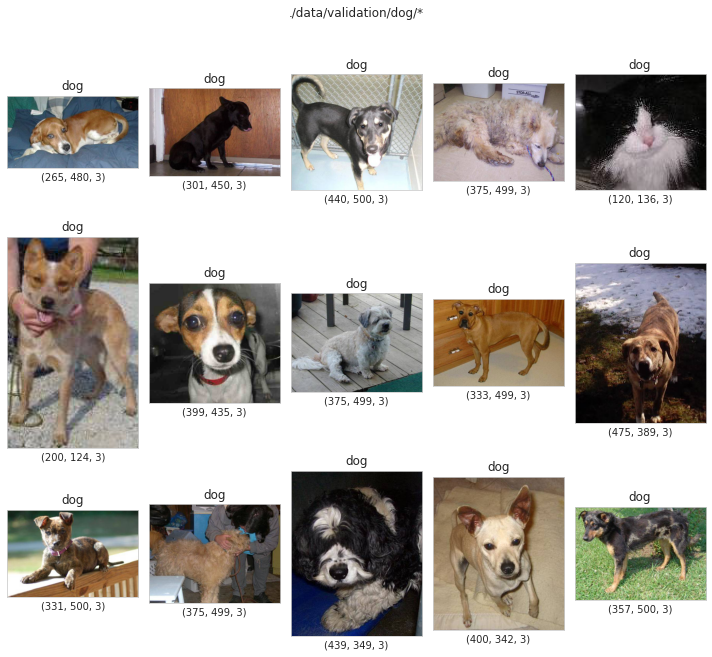

In [37]:
# View a random 15 image from the validation dataset
view_n_image(
    target_dir=val_path,
    target_class="dog",
    random_N_img=15
)

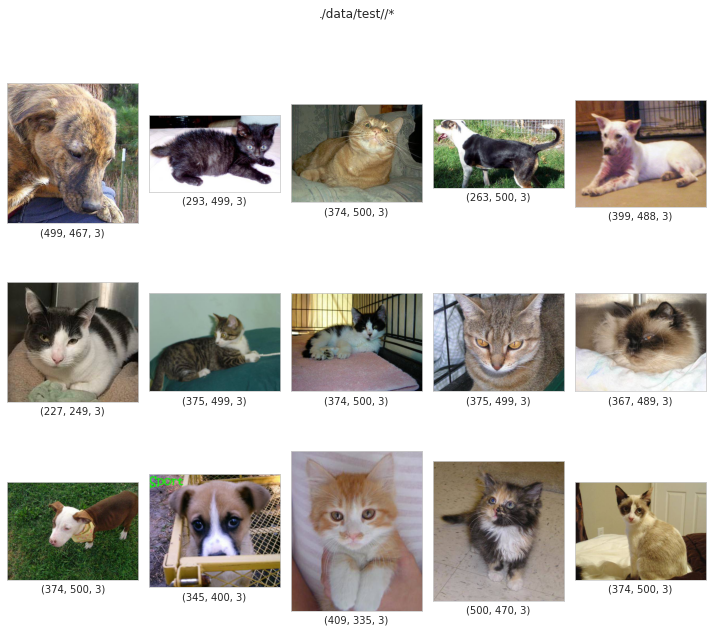

In [38]:
# View a first 15 image from the test dataset
view_n_image(
    target_dir=test_path,
    target_class=""
)

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [39]:
mpl.image.imread(train_file_paths[0]).shape

(374, 500, 3)

In [40]:
mpl.image.imread(train_file_paths[-1]).shape

(384, 499, 3)

In [41]:
# %%time
# # Wall time: 1min 31s * 2   ->  only cat
# x_train_shape_x = [mpl.image.imread(train_path+'/cat/'+image).shape[0] for image in os.listdir(train_path+'/cat')] 
# x_train_shape_y = [mpl.image.imread(train_path+'/cat/'+image).shape[1] for image in os.listdir(train_path+'/cat')]

# x_train_shape_x[:5], x_train_shape_y[:5]

# print(np.mean(x_train_shape_x), np.median(x_train_shape_x))
# print(np.mean(x_train_shape_y), np.median(x_train_shape_y))

(374, 500, 397, 499, 447) (500, 436, 212, 401, 321) 

x_train_shape_x:
 mean     358.929
median   374.000
dtype: float64 

x_train_shape_y:
 mean     407.216
median   453.000
dtype: float64
CPU times: user 47.8 s, sys: 1.3 s, total: 49.1 s
Wall time: 54.1 s


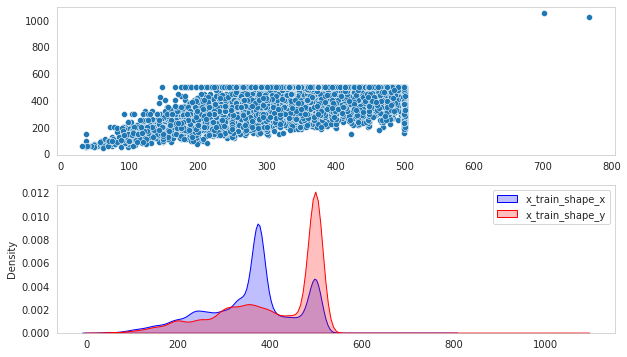

In [42]:
%%time
from glob import glob
import matplotlib as mpl
x_train_shape_x, x_train_shape_y, _ = zip(*pd.Series(glob(train_path + '/*/*')).map(lambda x: mpl.image.imread(x).shape))

print(x_train_shape_x[:5], x_train_shape_y[:5], "\n")

print(f"x_train_shape_x:\n {pd.Series(x_train_shape_x).agg(['mean', 'median'])} \n")
print(f"x_train_shape_y:\n {pd.Series(x_train_shape_y).agg(['mean', 'median'])}")

plt.subplot(211)
sns.scatterplot(x=x_train_shape_x, y=x_train_shape_y);

plt.subplot(212)
sns.kdeplot(x_train_shape_x, color='b', fill=True, label='x_train_shape_x');
sns.kdeplot(x_train_shape_y, color='r', fill=True, label='x_train_shape_y');
plt.legend();

(374, 408, 245, 199, 485) (500, 353, 299, 150, 500) 

x_val_shape_x:
 mean     359.508
median   374.000
dtype: float64 

x_val_shape_y:
 mean     405.152
median   446.500
dtype: float64
CPU times: user 5.21 s, sys: 223 ms, total: 5.44 s
Wall time: 5.31 s


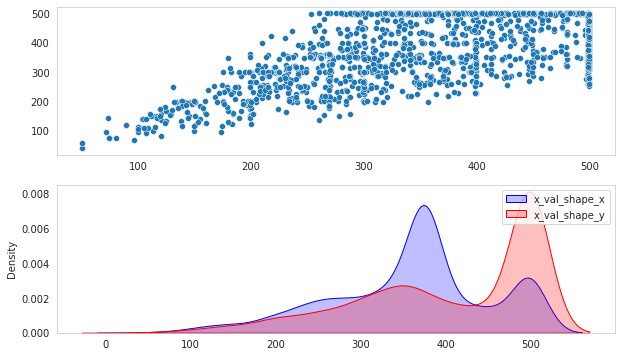

In [ ]:
%%time
from glob import glob
import matplotlib as mpl
x_val_shape_x, x_val_shape_y, _ = zip(*pd.Series(glob(val_path + '/*/*')).map(lambda x: mpl.image.imread(x).shape))

print(x_val_shape_x[:5], x_val_shape_y[:5], "\n")

print(f"x_val_shape_x:\n {pd.Series(x_val_shape_x).agg(['mean', 'median'])} \n")
print(f"x_val_shape_y:\n {pd.Series(x_val_shape_y).agg(['mean', 'median'])}")

plt.subplot(211)
sns.scatterplot(x=x_val_shape_x, y=x_val_shape_y);

plt.subplot(212)
sns.kdeplot(x_val_shape_x, color='b', fill=True, label='x_val_shape_x');
sns.kdeplot(x_val_shape_y, color='r', fill=True, label='x_val_shape_y');
plt.legend();

(359, 374, 500, 261, 459) (500, 353, 299, 150, 500) 

x_test_shape_x:
 mean     360.484
median   374.000
dtype: float64 

x_test_shape_y:
 mean     404.246
median   447.000
dtype: float64
CPU times: user 15.5 s, sys: 422 ms, total: 16 s
Wall time: 15.8 s


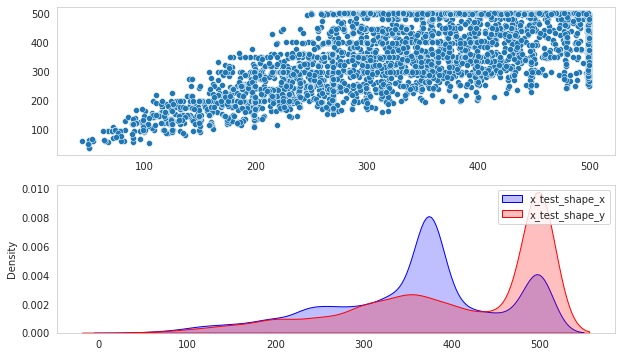

In [ ]:
%%time
from glob import glob
import matplotlib as mpl
x_test_shape_x, x_test_shape_y, _ = zip(*pd.Series(glob(test_path + '/*')).map(lambda x: mpl.image.imread(x).shape))

print(x_test_shape_x[:5], x_val_shape_y[:5], "\n")

print(f"x_test_shape_x:\n {pd.Series(x_test_shape_x).agg(['mean', 'median'])} \n")
print(f"x_test_shape_y:\n {pd.Series(x_test_shape_y).agg(['mean', 'median'])}")

plt.subplot(211)
sns.scatterplot(x=x_test_shape_x, y=x_test_shape_y);

plt.subplot(212)
sns.kdeplot(x_test_shape_x, color='b', fill=True, label='x_test_shape_x');
sns.kdeplot(x_test_shape_y, color='r', fill=True, label='x_test_shape_y');
plt.legend();

359.3798150713136 374.0
406.27248905027517 450.0


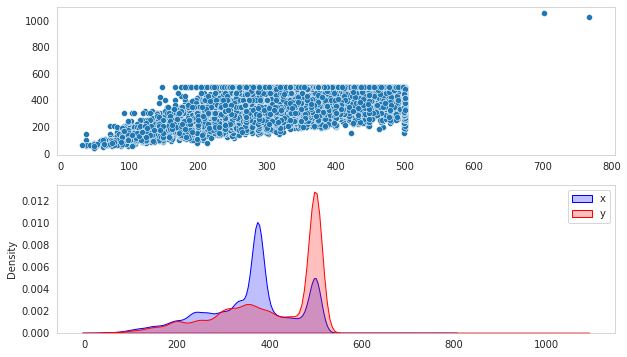

In [ ]:
x = np.hstack([x_train_shape_x, x_val_shape_x, x_test_shape_x])
y = np.hstack([x_train_shape_y, x_val_shape_y, x_test_shape_y])

x.shape, y.shape

print(np.mean(x), np.median(x))
print(np.mean(y), np.median(y))

plt.subplot(211)
sns.scatterplot(x=x, y=y);

plt.subplot(212)
sns.kdeplot(x, color='b', fill=True, label='x');
sns.kdeplot(y, color='r', fill=True, label='y');
plt.legend();

In [52]:
IMAGE_SHAPE = (350, 400, 3)

## Scalling

**Let's check the images if they are needed to be scaled or not**

- https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [43]:
mpl.image.imread(train_file_paths[0]).min(), mpl.image.imread(train_file_paths[0]).max()

(0, 255)

# Convolutional Neural Network Modeling

In [44]:
# !pip install tensorflow -Uq
import tensorflow as tf
# !pip install tensorflow-addons -Uq
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

# !pip install scikeras[tensorflow] -Uq
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [45]:
# !pip install scikit-plot -Uq
import scikitplot as skplt

## Eval Metric Convolutional Neural Network

In [46]:
def eval_metric(model, X_train, y_train, X_test, y_test, pipe = False):
    from sklearn.metrics import confusion_matrix, classification_report
    if pipe:
        y_pred_test  = model[-1].predict(model[:-1].transform(X_test)) >= 0.5
        y_pred_train = model[-1].predict(model[:-1].transform(X_train)) >= 0.5
    else:
        y_pred_test = model.predict(X_test) >= 0.5 # model.predict_classes(X_test) for tf 2.5.0
        y_pred_train = model.predict(X_train) >= 0.5
      
    print('TEST')    
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    print("-------------------------------------------------------")
    print('TRAIN')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

In [47]:
def plot_history(history, pipe=True):
    # Plot training results
    if pipe:
        H = history[-1].history.history
    else:
        H = history.history
    
    fig = plt.figure(figsize = (18, 7))

    plt.subplot(121)
    plt.plot(H['loss'], label = 'loss')
    plt.plot(H['val_loss'], label = 'val_loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(H['recall'], label = 'recall')
    plt.plot(H['val_recall'], label = 'val_recall')
    plt.grid()
    plt.legend()

In [48]:
def plot_metrics(history, metrics_names, pipe=True):
    colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if pipe:
        history = history[-1].history
    else:
        history = history

    fig = plt.figure(figsize = (14, 10))

    for n, metric in enumerate(metrics_names):
        name = str(metric).replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color='xkcd:dodger blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='salmon', ls="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name, fontsize=12)
        plt.legend()
        plt.tight_layout(pad=0.3)
        if metric == 'loss':
            plt.ylim(top=plt.ylim()[1])
        else: # plt.ylim(plt.gca().get_ylim())
            plt.ylim(bottom=plt.ylim()[0])

## Image Data Generator and Data Augmentation

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [49]:
import tensorflow as tf

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.7,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255, 
    preprocessing_function=None,
    validation_split=0.0,
)
img_gen

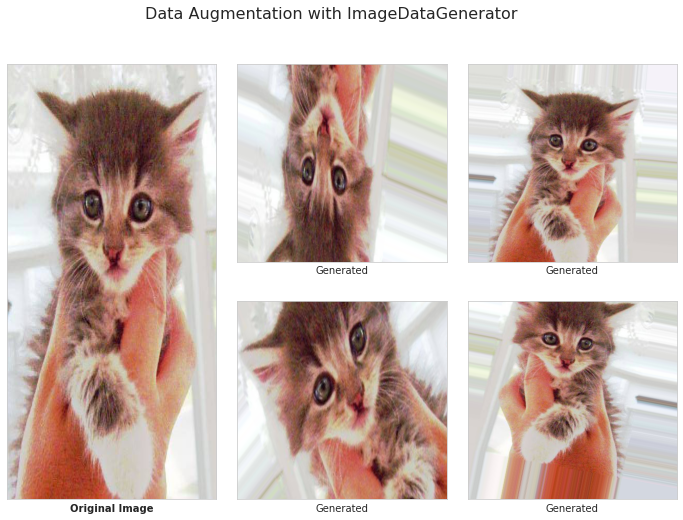

In [50]:
# !pip install -Uq matplotlib-dashboard
from matplotlib_dashboard import MatplotlibDashboard

#create figure to be used as dashboard
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Data Augmentation with ImageDataGenerator', fontsize=16)

dashboard = MatplotlibDashboard([
    ['left', 'first',  'third'],
    ['left', 'second', 'fourth'],
], wspace=0.1, hspace=0.2, figure = fig)

# drawing plots ...
dashboard['left'].imshow(imread(sorted(train_file_paths)[3]), aspect='auto');
dashboard['left'].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
dashboard['left'].set_xlabel(f'Original Image', fontweight ='bold')

dashboard['first'].imshow(img_gen.random_transform(imread(sorted(train_file_paths)[3])), aspect='auto');
dashboard['first'].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
dashboard['first'].set_xlabel(f'Generated');

dashboard['second'].imshow(img_gen.random_transform(imread(sorted(train_file_paths)[3])), aspect='auto');
dashboard['second'].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
dashboard['second'].set_xlabel(f'Generated');

dashboard['third'].imshow(img_gen.random_transform(imread(sorted(train_file_paths)[3])), aspect='auto');
dashboard['third'].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
dashboard['third'].set_xlabel(f'Generated');

dashboard['fourth'].imshow(img_gen.random_transform(imread(sorted(train_file_paths)[3])), aspect='auto');
dashboard['fourth'].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
dashboard['fourth'].set_xlabel(f'Generated');

plt.show()

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [53]:
STEPS_PER_EPOCH = np.ceil(total_train/BATCH_SIZE)
IMAGE_SHAPE = IMAGE_SHAPE
BATCH_SIZE  = BATCH_SIZE
SEED        = None

train_data_gen = img_gen.flow_from_directory(    
    directory=train_path,
    target_size=IMAGE_SHAPE[:2],
    color_mode='rgb',
    classes=None,
    class_mode='binary',  #'categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,  # 'training'
    interpolation='nearest',
#     keep_aspect_ratio=False
)
val_data_gen = img_gen.flow_from_directory(
    directory=val_path,
    target_size=IMAGE_SHAPE[:2],
    color_mode='rgb',
    classes=None,
    class_mode='binary',  #'categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
)
test_data_gen = img_gen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE[:2],
    color_mode='rgb',
    classes=None,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
)
print(type(train_data_gen))

Found 17526 images belonging to 2 classes.
Found 2290 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>


#### class_indices

In [54]:
train_data_gen.class_indices, train_data_gen.classes

({'cat': 0, 'dog': 1}, array([0, 0, 0, ..., 1, 1, 1], dtype=int32))

In [55]:
val_data_gen.class_indices, val_data_gen.classes

({'cat': 0, 'dog': 1}, array([0, 0, 0, ..., 1, 1, 1], dtype=int32))

In [56]:
test_data_gen.class_indices, test_data_gen.classes

({}, array([], dtype=int32))

#### shape

In [57]:
train_data_gen[0][0].shape

(64, 350, 400, 3)

In [58]:
val_data_gen[0][0].shape

(64, 350, 400, 3)

In [59]:
train_data_gen[0][0][0].shape

(350, 400, 3)

In [60]:
train_data_gen[0][0][0].min(), train_data_gen[0][0][0].max()

(0.0, 1.0)

#### batch_size and steps_per_epoch

In [61]:
np.ceil(total_train / BATCH_SIZE), np.ceil(total_val / BATCH_SIZE)

(274.0, 36.0)

In [62]:
# find steps_per_epoch
len(train_data_gen), len(val_data_gen), len(test_data_gen), 

(274, 36, 0)

In [63]:
len(train_data_gen)*BATCH_SIZE, len(val_data_gen)*BATCH_SIZE, len(test_data_gen)*BATCH_SIZE, 

(17536, 2304, 0)

#### data generator's image

In [64]:
# Get a sample of the training data batch 
# images, labels = next(img_gen.flow_from_directory(train_path))
images, labels = train_data_gen.next() # get the 'next' batch of images/labels

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (64, 350, 400, 3)
float32 (64,)


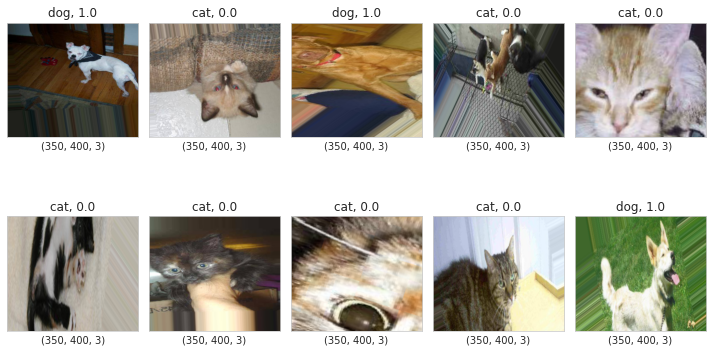

In [65]:
# train_data_gen first 8 images
for i in range(10):
    plt.subplot(2, 5, 1+i)
    # plt.imshow(np.array(images[i], np.uint8))
    plt.imshow(images[i])
    plt.title(f"{CLASS_NAMES[int(labels[i])]}, {labels[i]}")
    plt.xlabel(f'{images[i].shape}');
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()

## Build Dataset from Image Generator, But Not Required

In [66]:
# Not Compatible TPU
dataset_train = tf.data.Dataset.from_generator(
    lambda : train_data_gen,                     # Generator
    output_types=(tf.int32, tf.float32),         # How we're expecting our output dtype
    output_shapes=((None, 350, 400, 3), (None,)) # How we're expecting our output shape
)
dataset_val = tf.data.Dataset.from_generator(
    lambda : val_data_gen, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((None, 350, 400, 3), (None,))
)
dataset_test = tf.data.Dataset.from_generator(
    lambda : test_data_gen, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((None, 350, 400, 3), (None,))
)
print(dataset_train.element_spec, dataset_val.element_spec, dataset_test.element_spec, sep='\n')

(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [67]:
train_ds = dataset_train.map(lambda x, y: ({'conv2d_input': x}, y))
val_ds   = dataset_val.map(lambda x, y: ({'conv2d_input': x}, y))
test_ds  = dataset_test.map(lambda x, y: ({'conv2d_input': x}, ))

print(train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, sep='\n')

({'conv2d_input': TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))
({'conv2d_input': TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))
({'conv2d_input': TensorSpec(shape=(None, 350, 400, 3), dtype=tf.int32, name=None)},)


In [68]:
for image, label in train_ds.take(1):
  print("Image shape: ", image['conv2d_input'].numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (64, 350, 400, 3)
Label:  (64,)


### Dataset Shard Policy for kaggle GPU Warning

In [69]:
if gpus: 
    # Kaggle Warning -> Shard Policy for GPU
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    
    train_ds = train_ds.with_options(options)
#     train_ds2= train_ds2.with_options(options)
    val_ds   = val_ds.with_options(options)
    test_ds  = test_ds.with_options(options)
    print('Apply Shard Policy for GPU')
else:
    print('Passed')

Apply Shard Policy for GPU


# Build the Model with Image Generator (not work TPU)

In [70]:
print("Model Defined Shape: ", IMAGE_SHAPE)        # Input Layer Shape

# way-1
def build_classifier_model(
        input_shape: int = IMAGE_SHAPE,
        units:int        = 128,
) -> tf.keras.models.Model:    
    import tensorflow as tf    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))  
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())  
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=units, kernel_size=(3,3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units, activation='relu'))    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation='relu'))    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)

    model.compile(optimizer = "adam", 
                  loss = 'binary_crossentropy',  # 'categorical_crossentropy', 
                  metrics = ['accuracy', 'Recall', precision_at_recall], 
                  # weighted_metrics=['Recall']
                  )
    return model

Model Defined Shape:  (350, 400, 3)


In [71]:
from sklearn.pipeline import Pipeline

tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)

with strategy.scope():  
    model = build_classifier_model()
    display(model.summary())

    pipe_cnn1 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 347, 397, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 173, 198, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 173, 198, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 173, 198, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 171, 196, 64)      18496     
                                                                 
 average_pooling2d (AverageP  (None, 85, 98, 64)       0

None

In [72]:
from collections import Counter

counter = Counter(train_data_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

{0: 1.0, 1: 2.487067250298448}

In [73]:
from sklearn.utils import class_weight

class_weights = dict(
    zip(np.unique(train_data_gen.classes),
        class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_data_gen.classes), 
            y = train_data_gen.classes)
))
print(class_weights)

{0: 0.70104, 1: 1.743533625149224}


In [74]:
early_stop = EarlyStopping(monitor='val_loss', mode="min",
                           verbose = 1, patience = 10, restore_best_weights = True)

In [ ]:
%%time
history = pipe_cnn1.fit(train_data_gen, cnn__validation_data = val_data_gen, cnn__validation_steps=len(val_data_gen), #cnn__validation_split = 0.1, cnn__batch_size = 16, 
                    cnn__epochs = 1000, cnn__steps_per_epoch=len(train_data_gen), cnn__verbose = 1, cnn__callbacks=[early_stop], cnn__class_weight=class_weights) # 

Epoch 1/1000
274/274 [==============================] - 632s 2s/step - loss: 0.7378 - accuracy: 0.5677 - recall: 0.5571 - precision_at_recall: 0.3095 - val_loss: 0.7935 - val_accuracy: 0.5376 - val_recall: 0.0187 - val_precision_at_recall: 0.4948
Epoch 2/1000
274/274 [==============================] - 597s 2s/step - loss: 0.6637 - accuracy: 0.6076 - recall: 0.5975 - precision_at_recall: 0.3365 - val_loss: 0.7304 - val_accuracy: 0.5742 - val_recall: 0.1681 - val_precision_at_recall: 0.5423
Epoch 3/1000
274/274 [==============================] - 593s 2s/step - loss: 0.6335 - accuracy: 0.6486 - recall: 0.6216 - precision_at_recall: 0.3566 - val_loss: 0.6651 - val_accuracy: 0.6231 - val_recall: 0.5938 - val_precision_at_recall: 0.5261
Epoch 4/1000
274/274 [==============================] - 596s 2s/step - loss: 0.6116 - accuracy: 0.6649 - recall: 0.6281 - precision_at_recall: 0.3759 - val_loss: 0.6557 - val_accuracy: 0.6371 - val_recall: 0.3455 - val_precision_at_recall: 0.5414
Epoch 5/1000

In [ ]:
# save model permanently and check
# model.save_weights('first_try.h5')
pipe_cnn1[-1].save('/content/drive/MyDrive/cat_dog_data1.h5')

In [ ]:
history[-1].metrics_names

['loss', 'accuracy', 'recall', 'precision_at_recall']

In [ ]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(3)

loss  accuracy  recall  precision_at_recall  val_loss  val_accuracy  \
2 0.628     0.653   0.637                0.365     0.632         0.637   
3 0.601     0.676   0.656                0.391     0.688         0.539   
4 0.580     0.693   0.676                0.409     0.778         0.600   

   val_recall  val_precision_at_recall  
2       0.755                    0.567  
3       0.867                    0.518  
4       0.161                    0.542

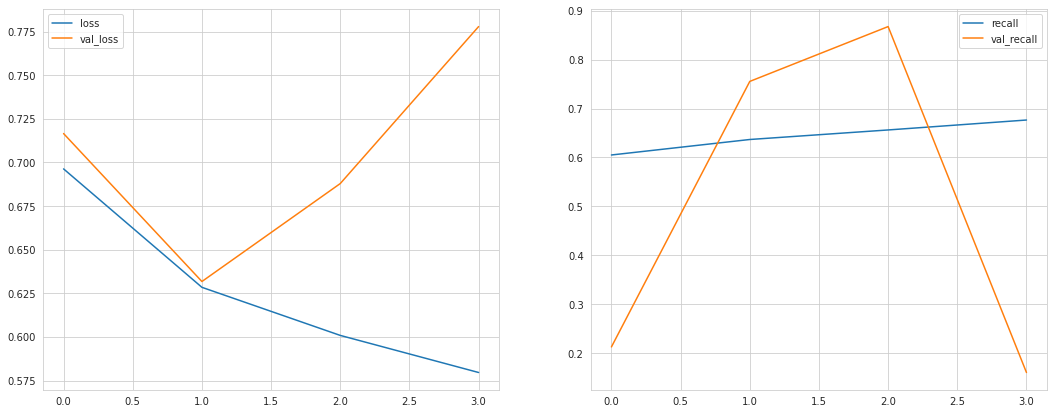

In [ ]:
# Plot training results
plot_history(history)

# Modelling-2

In [ ]:
print("Model Defined Shape: ", IMAGE_SHAPE)        # Input Layer Shape

# way-2
def build_classifier_model_cnn(
        input_shape: int = IMAGE_SHAPE,
        units:int        = 256,
) -> tf.keras.models.Model:
    import tensorflow as tf  
    
    inputs = tf.keras.layers.Input(shape=input_shape )
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)   
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)   
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)   
    
    x = tf.keras.layers.Conv2D(filters=units, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)   
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units, activation=tf.nn.relu)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs  = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="classifier_model") 

    precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss = tf.keras.losses.BinaryCrossentropy(), 
                  metrics = ['accuracy', tf.keras.metrics.Recall(), precision_at_recall], 
                  # weighted_metrics = [tf.keras.metrics.Recall()] 
                  )
    return model

Model Defined Shape:  (350, 400, 3)


In [ ]:
tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)

with strategy.scope():  
    model = build_classifier_model_cnn()
    display(model.summary())

    pipe_cnn2 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn2

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 347, 397, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 173, 198, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 173, 198, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 173, 198, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 170, 195, 64) 

None

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', mode="max",
                           verbose = 1, patience = 3, restore_best_weights = True)

In [ ]:
%%time
history = pipe_cnn2.fit(train_data_gen, cnn__validation_data = val_data_gen, cnn__validation_steps=len(val_data_gen), #cnn__validation_split = 0.1, cnn__batch_size = 16, 
                    cnn__epochs = 1000, cnn__steps_per_epoch=len(train_data_gen), cnn__verbose = 1, cnn__callbacks=[early_stop], cnn__class_weight=class_weights) # 

Epoch 1/1000
274/274 [==============================] - 617s 2s/step - loss: 0.7255 - accuracy: 0.5733 - recall: 0.5688 - precision_at_recall: 0.3120 - val_loss: 0.7569 - val_accuracy: 0.5389 - val_recall: 0.0168 - val_precision_at_recall: 0.4957
Epoch 2/1000
274/274 [==============================] - 609s 2s/step - loss: 0.6266 - accuracy: 0.6558 - recall: 0.6329 - precision_at_recall: 0.3690 - val_loss: 0.9403 - val_accuracy: 0.5795 - val_recall: 0.1307 - val_precision_at_recall: 0.5044
Epoch 3/1000
274/274 [==============================] - 607s 2s/step - loss: 0.5952 - accuracy: 0.6938 - recall: 0.6554 - precision_at_recall: 0.3920 - val_loss: 0.8733 - val_accuracy: 0.6162 - val_recall: 0.5789 - val_precision_at_recall: 0.5248
Epoch 4/1000
274/274 [==============================] - 605s 2s/step - loss: 0.5783 - accuracy: 0.7028 - recall: 0.6727 - precision_at_recall: 0.4100 - val_loss: 0.9038 - val_accuracy: 0.5659 - val_recall: 0.1279 - val_precision_at_recall: 0.5092
Epoch 5/1000

In [ ]:
# save model permanently and check
pipe_cnn2[-1].save('/content/drive/MyDrive/cat_dog_data2.h5')

In [ ]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(3)

loss  accuracy  recall  val_loss  val_accuracy  val_recall
3 0.565     0.702   0.695     0.669         0.585       0.700
4 0.547     0.717   0.713     0.553         0.723       0.681
5 0.524     0.739   0.723     0.636         0.694       0.479

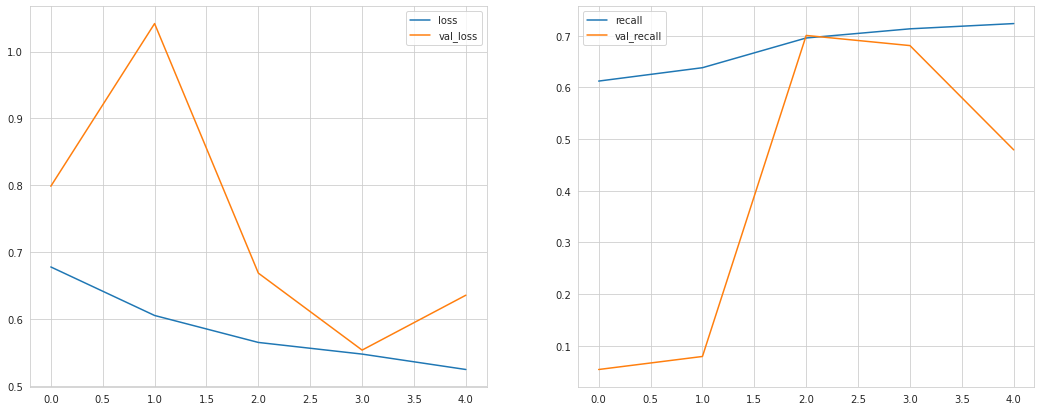

In [ ]:
# Plot training results
plot_history(history)

# Evaluation on Test Data

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/cat_dog_data1.h5')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/cat_dog_data2.h5')

In [ ]:
model1.evaluate(
    val_data_gen, 
    return_dict=True, verbose=0)

{'loss': 0.5684391856193542,
 'accuracy': 0.6917030811309814,
 'recall': 0.6928104758262634,
 'precision_at_recall': 0.6064879894256592}

In [ ]:
model2.evaluate(
    val_data_gen, 
    return_dict=True, verbose=0)

{'loss': 0.6720335483551025,
 'accuracy': 0.5816593766212463,
 'recall': 0.6965453028678894}

## Compare and Select Models

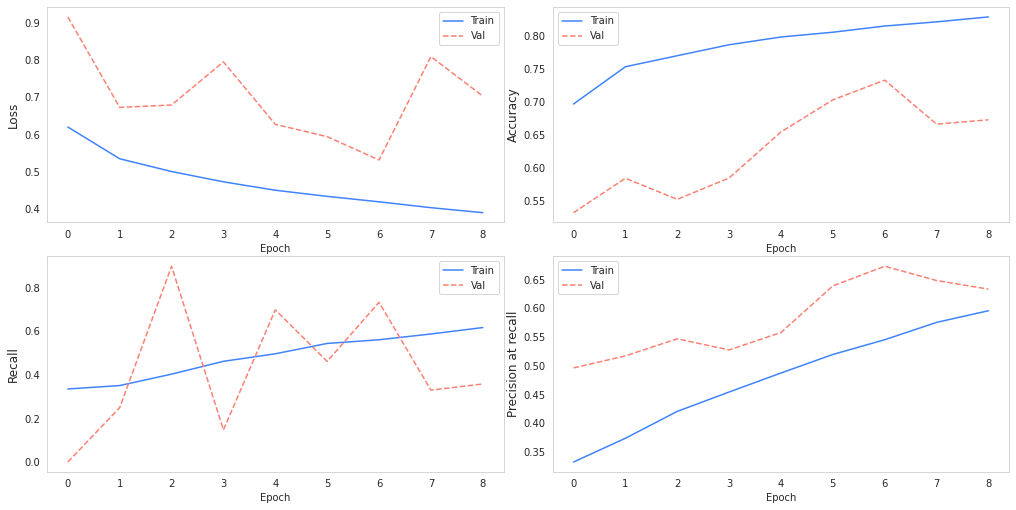

In [ ]:
plot_metrics(pipe_cnn1, pipe_cnn1[-1].metrics_names)

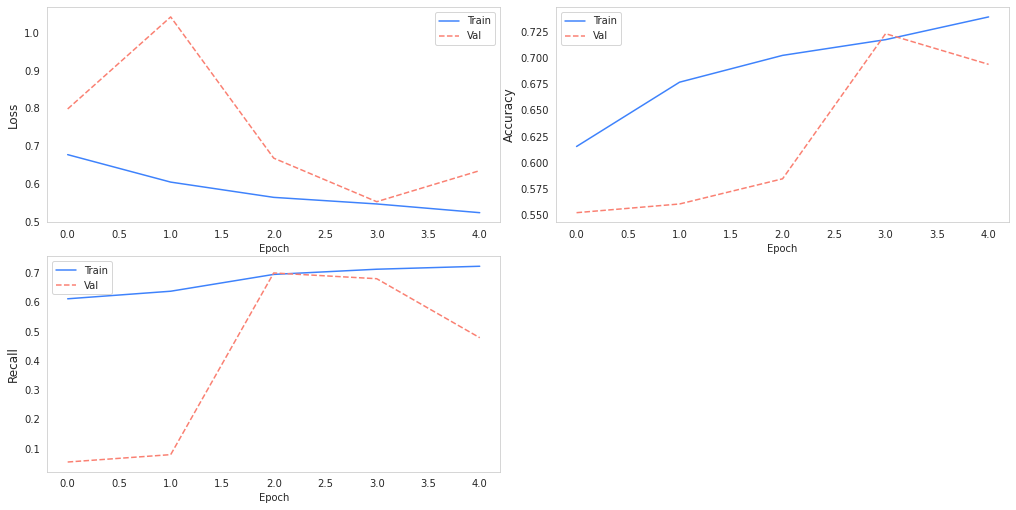

In [ ]:
plot_metrics(pipe_cnn2, pipe_cnn2[-1].metrics_names)

## Presiction Label Test Data

In [ ]:
# predict probabilities 
y_pred_prob_val  = model2.predict(val_data_gen, verbose=0)
y_pred_prob_train = model2.predict(train_data_gen, verbose=0)

y_pred_prob_val.shape, y_pred_prob_train.shape

((2290, 1), (17526, 1))

In [ ]:
# predict crisp classes 
y_pred_val  = y_pred_prob_val > 0.5
y_pred_train = y_pred_prob_train > 0.5

y_pred_val.shape, y_pred_train.shape

((2290, 1), (17526, 1))

In [ ]:
print(confusion_matrix(val_data_gen.classes, y_pred_val))
print(classification_report(val_data_gen.classes, y_pred_val))

[[595 624]
 [322 749]]
              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1219
           1       0.55      0.70      0.61      1071

    accuracy                           0.59      2290
   macro avg       0.60      0.59      0.59      2290
weighted avg       0.60      0.59      0.58      2290



In [ ]:
print(confusion_matrix(train_data_gen.classes, y_pred_train))
print(classification_report(train_data_gen.classes, y_pred_train))

[[5428 7072]
 [2158 2868]]
              precision    recall  f1-score   support

           0       0.72      0.43      0.54     12500
           1       0.29      0.57      0.38      5026

    accuracy                           0.47     17526
   macro avg       0.50      0.50      0.46     17526
weighted avg       0.59      0.47      0.50     17526



In [ ]:
(val_data_gen.classes != y_pred_val).sum()

2655794

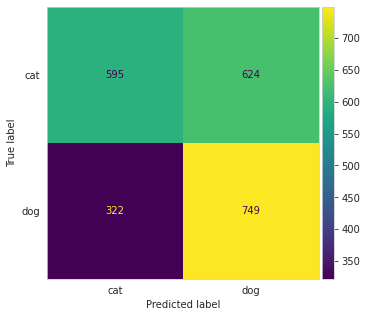

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    val_data_gen.classes, y_pred_val,
    # labels=classes
)

cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=CLASS_NAMES
)

fig, ax = plt.subplots(figsize=(5, 5))

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False)
plt.grid(False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+.01, ax.get_position().y0, .033, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_data_gen.classes, y_pred_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_data_gen.classes, y_pred_val, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_data_gen.classes, y_pred_val, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(val_data_gen.classes, y_pred_val, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.586900
Precision: 0.600527
Recall: 0.586900
F1 score: 0.583219


In [ ]:
# kappa
kappa = cohen_kappa_score(val_data_gen.classes, y_pred_val)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(val_data_gen.classes, y_pred_prob_val)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.184297
ROC AUC: 0.649115


# Prediction

In [ ]:
# View a random image
import random

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/cat_dog_data2.h5')

In [ ]:
target_class = random.choice(CLASS_NAMES)
target_class

'dog'

In [ ]:
random_image = random.sample(os.listdir(test_path), 1)
random_image

['2901.jpg']

In [ ]:
# image_path = 'cat-dog.jpg'
image_path = test_path +"/"+ random_image[0]
image_path

'./data/test/2901.jpg'

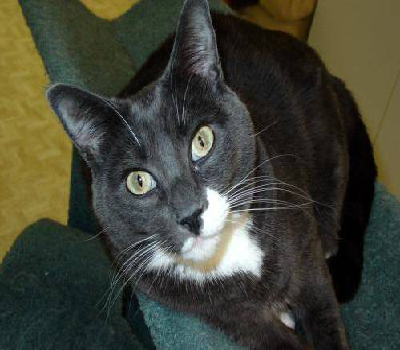

In [ ]:
my_image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SHAPE)
my_image

In [ ]:
my_image = tf.keras.preprocessing.img_to_array(my_image)
my_image.shape

(350, 400, 3)

In [ ]:
my_image = np.expand_dims(my_image, axis=0)
my_image.shape

(1, 350, 400, 3)

In [ ]:
model.predict(my_image) > 0.5

1/1 [==============================] - 1s 800ms/step


array([[False]])

In [ ]:
train_data_gen.class_indices

{'cat': 0, 'dog': 1}

# Prediction random Image from Test Folder

In [ ]:
def random_pred_and_plot(model, path=''):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # View a random image
    import random
    import tensorflow as tf
    from glob import glob

    # Get all image path
    image_list = glob("./data/test/*")

    if path == '':
        img_path = random.choice(image_list)
    else:
        img_path = path # specific local data

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=[350, 400])

    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
      pred_class = CLASS_NAMES[pred.argmax()] # if more than one output, take the max
    else:
      pred_class = CLASS_NAMES[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}, prob: {pred.max()}")
    plt.axis(False);

1/1 [==============================] - 0s 18ms/step
prediction_probability:  0.0


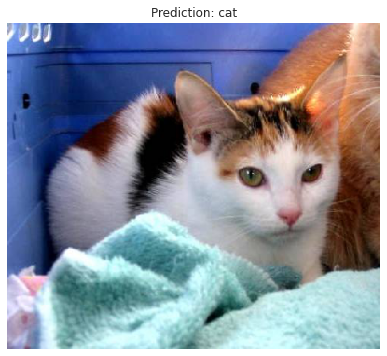

In [ ]:
random_pred_and_plot(model)

1/1 [==============================] - 0s 24ms/step
prediction_probability:  0.0


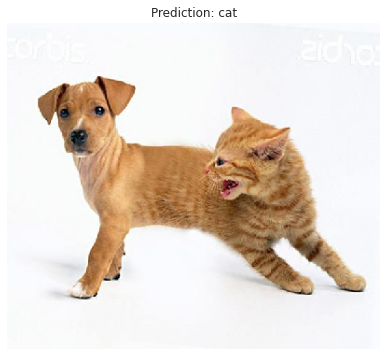

In [ ]:
random_pred_and_plot(model, path='cat-dog.jpg')

# End of the Project

# Image Dataset from Directory, Build the Model with input pipelines

In [ ]:
def dataset_pipeline(data_dir=data_dir,      
    BATCH_SIZE = BATCH_SIZE
):
    import os
    from glob import glob
    SIZE       = IMAGE_SHAPE[:2]
    AUTOTUNE   = tf.data.AUTOTUNE
    shuffle_buffer_size = 1000
    
    def get_label(file_path):
        # Convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        one_hot = parts[-2] == class_names
        # Integer encode the label
        return tf.argmax(one_hot)

    def process_path(file_path):
        file_path = file_path.numpy().decode("utf-8")
        # Load the raw data from the file as a string
        image = tf.io.read_file(filename=str(file_path))
        # Convert the compressed string to a 3D uint8 tensor
        image = tf.io.decode_image(contents=image, channels=3, expand_animations=False)
        # Use `convert_image_dtype` to convert to floats in the [0,1] range.
        image = tf.image.convert_image_dtype(image, tf.float32)
        # Resize the image to the desired size
        image = tf.image.resize(image, size=SIZE)    
        return image, get_label(file_path)

    def configure_for_performance(ds):
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.batch(BATCH_SIZE)        
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    filenames = glob(data_dir + '/*/*.jpg')
    class_names = np.unique(os.listdir(data_dir))

    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    filenames_ds = filenames_ds.shuffle(len(filenames), reshuffle_each_iteration=False)
    
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    ds = filenames_ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.int64]), num_parallel_calls=AUTOTUNE)
    ds = configure_for_performance(ds)

    # ds = filenames_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    # ds = configure_for_performance(ds)

    return ds

In [ ]:
train_ds = dataset_pipeline(train_path)
val_ds   = dataset_pipeline(val_path)
train_ds, val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (64, 350, 400, 3)
Label:  (64,)


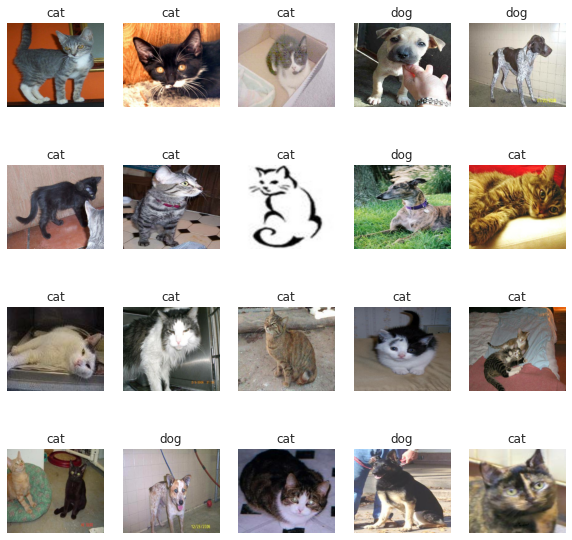

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(20):
      ax = plt.subplot(4, 5, n+1)
      plt.imshow(image_batch[n])
      plt.title(f"{CLASS_NAMES[label_batch[n]]}")
      plt.axis('off')

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

<a id="10"></a>

<a href="#content" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

<div style="align: center;">
    <p style="text-align:center; background-color:romance; color: #9d4f8c; border-radius:10px 10px; font-family:newtimeroman; 
              line-height:3.5; font-size:32px; font-weight:bold; text-transform: capitalize;">The End of the Project</p>
</div>